In [15]:
#Group project final EDA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [73]:
data = pd.read_csv('METABRIC_RNA_Mutation.csv')
cols = list(data.columns)

/var/folders/w3/cl4nd2c13k75gwd6t0xfksq40000gn/T/ipykernel_1827/240679187.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('METABRIC_RNA_Mutation.csv')


In [3]:
data.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


### Survival Months by Tumor Size and Type of Surgery ###

In [4]:
np.unique(list(data['type_of_breast_surgery']))

array(['BREAST CONSERVING', 'MASTECTOMY', 'nan'], dtype='<U32')

Text(0.5, 0, 'tumor_size')

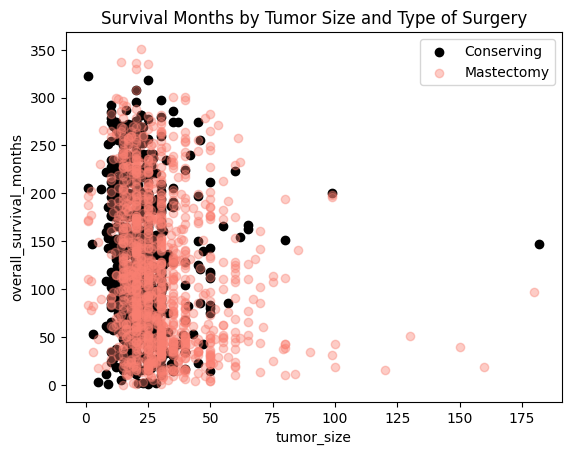

In [5]:
fig, ax = plt.subplots()
ax.scatter(data[data['type_of_breast_surgery']=='BREAST CONSERVING']['tumor_size'], data[data['type_of_breast_surgery']=='BREAST CONSERVING']['overall_survival_months'], color='k', label='Conserving')
ax.scatter(data[data['type_of_breast_surgery']=='MASTECTOMY']['tumor_size'], data[data['type_of_breast_surgery']=='MASTECTOMY']['overall_survival_months'], label='Mastectomy', color='salmon', alpha=0.4)
ax.legend(loc='upper right')
ax.set_title('Survival Months by Tumor Size and Type of Surgery')
ax.set_ylabel('overall_survival_months')
ax.set_xlabel('tumor_size')


### Density Estimate of Survival Months by Tumor Stage ###

Text(-7.579214506172844, 0.5, 'Density')

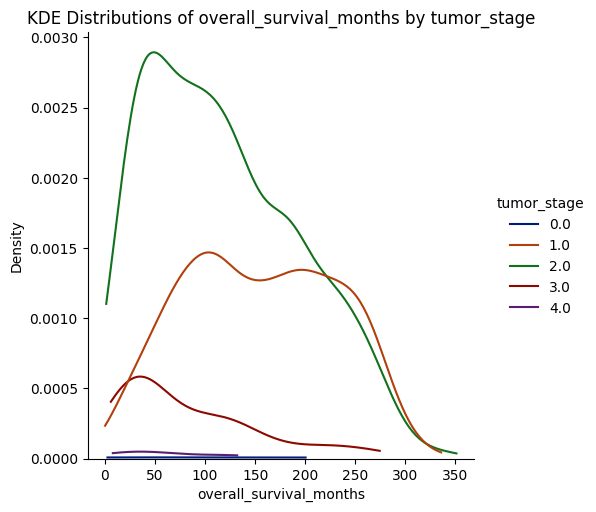

In [6]:
sns.displot(data, x="overall_survival_months", hue="tumor_stage", kind="kde", cut=0, palette='dark')
plt.title('KDE Distributions of overall_survival_months by tumor_stage')
plt.xlabel('overall_survival_months')
plt.ylabel('Density')

### Gene Mutation Data on Survival Months and Death from Cancer ###
In this section we look at several simple models to predict the overall_survival_months as well as death_from_cancer features. First the models are implemented without the gene mutation data and only on clinical variables such as age_at_diagnosis and tumor_size. Next we employ PCA on the gene mutation data and include the PCs in the regression analysis to see how much information the gene mutations contain for the two dependent variables. We also look at models with just a handful of gene mutations that appear to be the most relevant.

In [94]:
#Multiple Linear Regression without gene mutation data
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

Y1 = data['overall_survival_months']
Y2 = data['death_from_cancer']
X1 = data[['age_at_diagnosis', 'mutation_count', 'neoplasm_histologic_grade', 'nottingham_prognostic_index', 'tumor_size', 'tumor_stage', 'radio_therapy', 'chemotherapy', 'hormone_therapy', 'lymph_nodes_examined_positive']]

#Multiple linear regression
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)

#Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

#Predict on the test set
y_pred = model.predict(X_test)

#Model output
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

#Using statsmodels to get summary table
X_sm = sm.add_constant(X1)
model_sm = sm.OLS(Y1, X_sm).fit()
#Print summary table
print(model_sm.summary())



Coefficients: [ -1.01550133   0.53728599  -0.72332482  -4.734128    -0.24158407
 -11.63546521   7.01485574 -27.71951529  -7.54382385  -2.24164845]
Intercept: 242.782283267568
Mean Squared Error: 5472.291677964358
R² Score: 0.1408066869924811
                               OLS Regression Results                              
Dep. Variable:     overall_survival_months   R-squared:                       0.147
Model:                                 OLS   Adj. R-squared:                  0.139
Method:                      Least Squares   F-statistic:                     18.65
Date:                     Sun, 10 Aug 2025   Prob (F-statistic):           7.70e-32
Time:                             15:27:42   Log-Likelihood:                -6207.4
No. Observations:                     1092   AIC:                         1.244e+04
Df Residuals:                         1081   BIC:                         1.249e+04
Df Model:                               10                                         
Co

There are a number of variables included in the regression that are not statistically significant such as neoplasm_histologic_grade. The MSE of this model on the test set was 5,472 and it has an R2 of 0.15.

In [20]:
np.unique(y_train2)

array(['Died of Disease', 'Died of Other Causes', 'Living'], dtype=object)

In [16]:
#Logistic regression for the death_from_cancer variable using the same features as above
X_train2, X_test2, y_train2, y_test2 = train_test_split(X1, Y2, test_size=0.3, random_state=42)

# 4. Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train2, y_train2)

# 5. Predict on the test set
y_pred2 = model.predict(X_test2)

# 6. Evaluate the model
print("Accuracy:", accuracy_score(y_test2, y_pred2))
print("\nClassification Report:\n", classification_report(y_test2, y_pred2))
print("\nConfusion Matrix:\n", confusion_matrix(y_test2, y_pred2))

# Optional: Check model coefficients
print("\nIntercept:", model.intercept_)
print("Coefficients:", model.coef_)

Accuracy: 0.524390243902439

Classification Report:
                       precision    recall  f1-score   support

     Died of Disease       0.55      0.37      0.44       116
Died of Other Causes       0.42      0.42      0.42        72
              Living       0.55      0.71      0.62       140

            accuracy                           0.52       328
           macro avg       0.51      0.50      0.49       328
        weighted avg       0.52      0.52      0.51       328


Confusion Matrix:
 [[43 22 51]
 [13 30 29]
 [22 19 99]]

Intercept: [-0.22699729 -0.44052391  0.6675212 ]
Coefficients: [[-1.60201697e-02  1.76328236e-02  7.27037869e-02  2.02646800e-01
   1.30331251e-02  2.01450742e-02 -2.45229097e-01  1.43384582e-01
  -1.25072691e-01  4.93608241e-02]
 [ 3.98200084e-02 -1.13743843e-04 -1.18607854e-01 -3.82474637e-01
   3.73117708e-03 -2.63105211e-01 -5.24498064e-01 -3.06772869e-01
   4.15173049e-03  7.47601057e-02]
 [-2.37998387e-02 -1.75190797e-02  4.59040674e-02  1.79

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


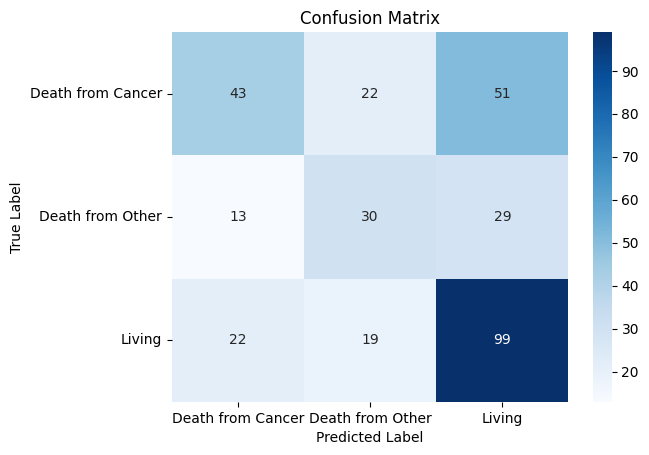

In [29]:
cm = confusion_matrix(y_test2, y_pred2)

# Define class names (0 = No, 1 = Yes)
labels = ['Death from Cancer', 'Death from Other', 'Living']

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Now we include the gene data after applying PCA to see if the gene mutation data will contribute to the accuracy of predictions.


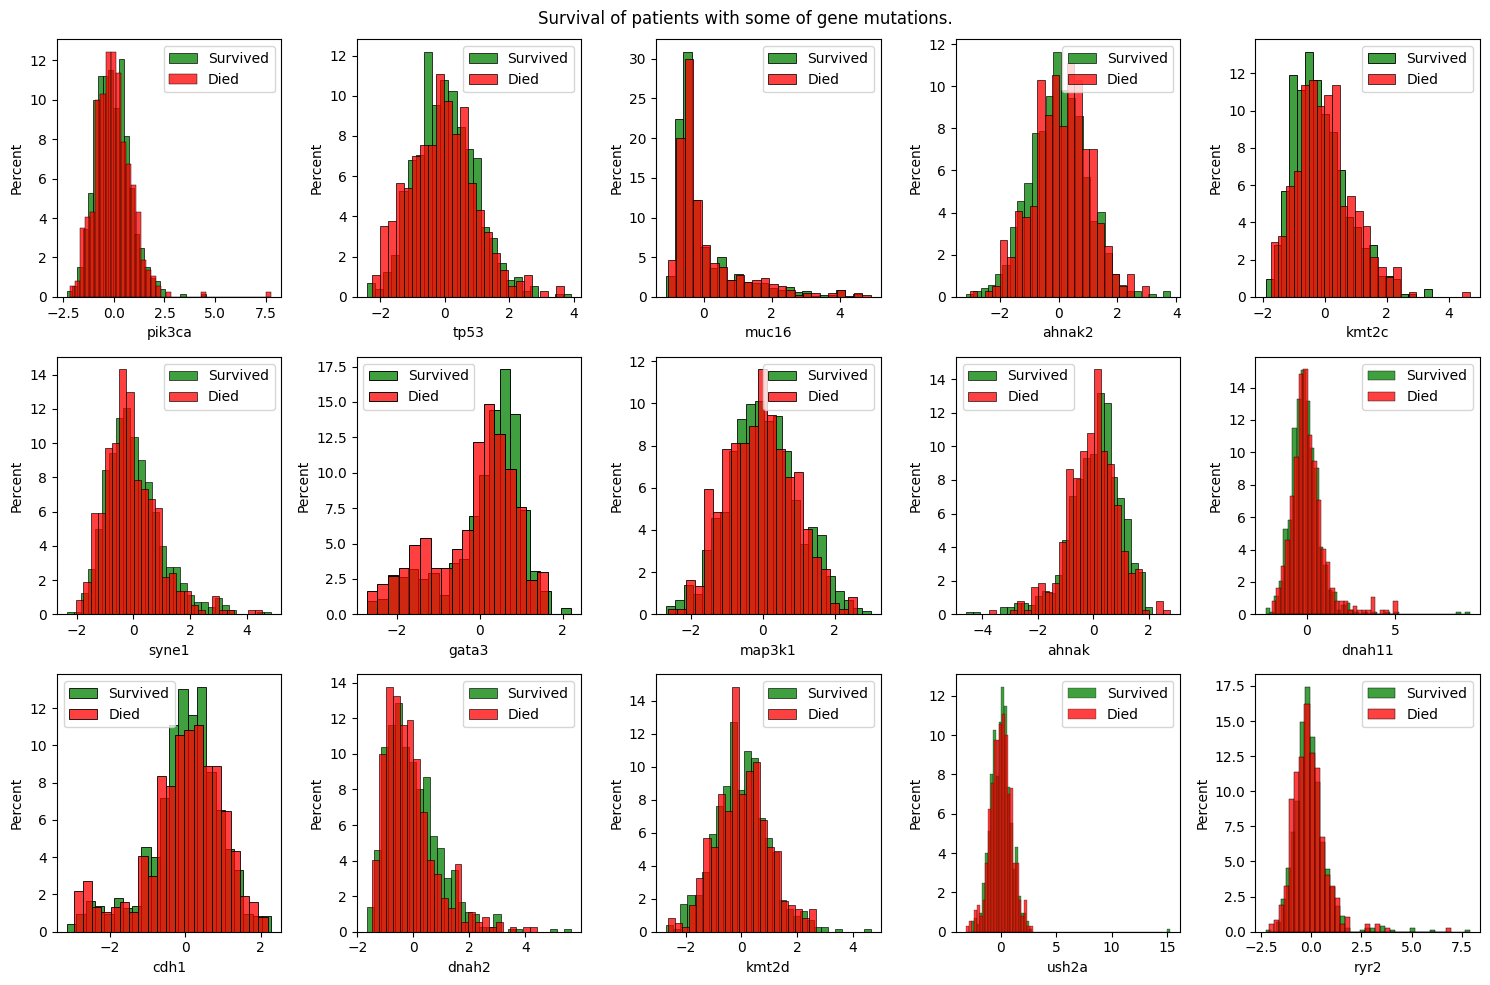

In [105]:
columns = ['pik3ca','tp53','muc16','ahnak2','kmt2c','syne1','gata3','map3k1','ahnak','dnah11','cdh1','dnah2','kmt2d','ush2a','ryr2']   
fig, axs = plt.subplots(3, 5, figsize=(15, 10))
fig.suptitle('Survival of patients with some of gene mutations.')

for i,ax in zip(data.loc[:,columns].columns,axs.flatten()):
    sns.histplot(data[i][data['death_from_cancer']!='Died of Disease'], color='g', label = 'Survived',ax=ax, stat='percent', binwidth=0.25)
    sns.histplot(data[i][data['death_from_cancer']=='Died of Disease'], color='r', label = 'Died',ax=ax, stat='percent', binwidth=0.25)
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [75]:
gene_data = data.iloc[:, 31:-173]
gene_data.head()

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
1,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,...,-0.4412,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-0.8920
4,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,...,-0.5845,-0.3544,-1.0150,2.2961,0.1817,-0.1572,0.0427,5.0048,3.8476,1.3223
5,-0.4341,0.6931,0.6909,1.0840,-1.9371,0.9252,1.1520,0.7951,-0.9677,-0.7750,...,-0.3910,0.0395,0.8191,0.1977,-0.2302,-0.5092,-0.3021,0.9357,-0.4217,0.5340
8,0.8347,-1.5038,0.3436,-0.5550,0.0558,-0.9155,-0.8571,-0.1267,-0.1705,0.6442,...,-0.3917,-0.1405,-0.9780,-0.3030,-0.1640,1.0783,1.8263,-0.5965,0.1502,-0.8837
9,-1.0087,-0.6074,0.0313,1.0975,0.5314,0.9105,-1.5068,-0.0196,0.3726,0.4892,...,-0.3020,-0.4788,3.6125,1.9925,0.2253,-0.8414,1.7093,-0.6921,0.6906,-0.8006


In [76]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def perform_pca(df, n_components):
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # Apply PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(scaled_data)

    # Create a DataFrame with the principal components
    pc_columns = [f'PC{i+1}' for i in range(n_components)]
    pc_df = pd.DataFrame(data=principal_components, columns=pc_columns)

    return pc_df, pca.explained_variance_ratio_


pc_df, var_expl = perform_pca(gene_data, 100)

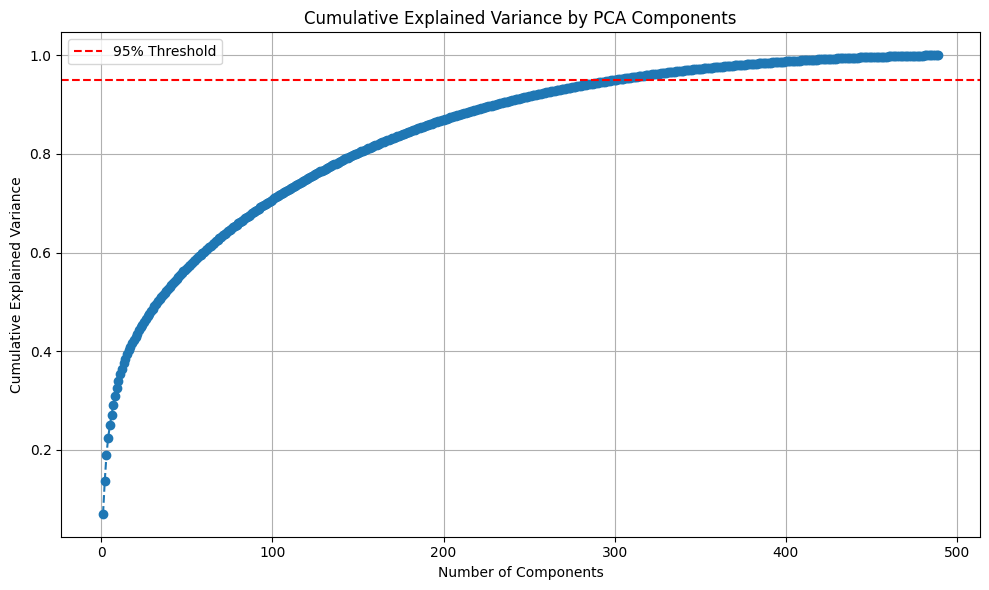

In [77]:
def plot_pca_variance(df):
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # Apply PCA with all components
    pca = PCA()
    pca.fit(scaled_data)

    # Explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = explained_variance_ratio.cumsum()

    # Scree plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pca_variance(gene_data)

In [99]:
pc_df.to_csv('PC_full.csv')

In [78]:
data.reset_index(inplace=True, drop=True)
pc_df.reset_index(inplace=True, drop=True)

In [81]:
data_pcs = pd.concat([data, pc_df], axis=1)

In [86]:
#Logistic Regression with first 25 PCs
#Logistic regression for the death_from_cancer variable using the same features as above
X3 = data_pcs[['age_at_diagnosis', 'mutation_count', 'neoplasm_histologic_grade', 'nottingham_prognostic_index', 'tumor_size', 'tumor_stage', 'radio_therapy', 'chemotherapy', 'hormone_therapy', 'lymph_nodes_examined_positive', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25']]


X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, Y2, test_size=0.3, random_state=42)

# 4. Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train3, y_train3)

# 5. Predict on the test set
y_pred3 = model.predict(X_test3)

# 6. Evaluate the model
print("Accuracy:", accuracy_score(y_test3, y_pred3))
print("\nClassification Report:\n", classification_report(y_test3, y_pred3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test3, y_pred3))

# Optional: Check model coefficients
print("\nIntercept:", model.intercept_)
print("Coefficients:", model.coef_)


Accuracy: 0.5701219512195121

Classification Report:
                       precision    recall  f1-score   support

     Died of Disease       0.53      0.48      0.51       116
Died of Other Causes       0.49      0.46      0.47        72
              Living       0.63      0.70      0.66       140

            accuracy                           0.57       328
           macro avg       0.55      0.55      0.55       328
        weighted avg       0.56      0.57      0.57       328


Confusion Matrix:
 [[56 20 40]
 [21 33 18]
 [28 14 98]]

Intercept: [-0.07193072 -0.2302933   0.30222402]
Coefficients: [[-1.10609658e-02 -2.13416781e-04 -4.33822933e-02  1.28035301e-01
   1.57755637e-02  4.10249200e-02 -1.05096811e-01  1.11686806e-01
  -3.40346861e-02  4.01753327e-02  2.53782942e-02 -2.39037800e-02
   1.23251545e-02  1.68059095e-02  5.85614665e-02 -6.70259734e-03
  -4.30427992e-03 -2.41067483e-03  3.16294718e-02  3.29362860e-02
  -5.55865403e-05  5.48823136e-03 -3.91856266e-02  1.35215

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


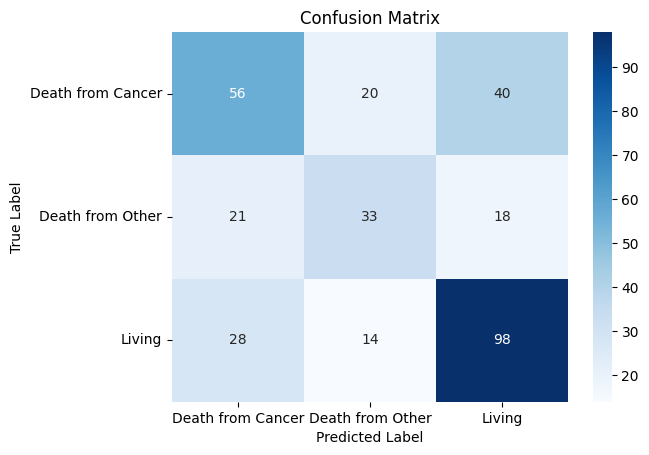

In [87]:
cm = confusion_matrix(y_test3, y_pred3)

# Define class names
labels = ['Death from Cancer', 'Death from Other', 'Living']

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [89]:
feature_names = X3.columns
coefficients = model.coef_[0]

#Contribution of each feature (coefficient)
contrib_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(contrib_df)

                          Feature  Coefficient
3     nottingham_prognostic_index     0.128035
7                    chemotherapy     0.111687
6                   radio_therapy    -0.105097
30                           PC21    -0.092377
34                           PC25     0.059653
14                            PC5     0.058561
32                           PC23     0.051246
2       neoplasm_histologic_grade    -0.043382
5                     tumor_stage     0.041025
31                           PC22    -0.040905
9   lymph_nodes_examined_positive     0.040175
22                           PC13    -0.039186
24                           PC15     0.036828
8                 hormone_therapy    -0.034035
19                           PC10     0.032936
18                            PC9     0.031629
10                            PC1     0.025378
11                            PC2    -0.023904
25                           PC16    -0.021970
33                           PC24    -0.018959
26           

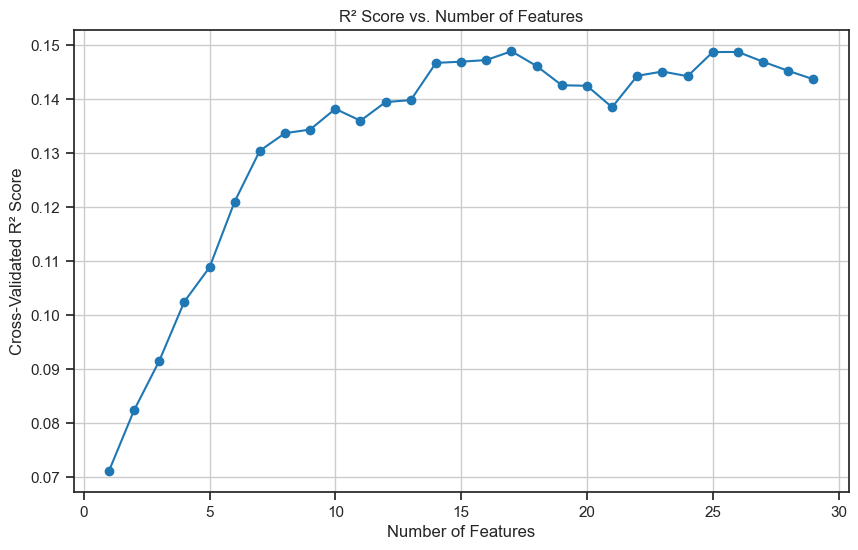

Best number of features: 17
Best cross-validated R²: 0.1489
Selected features: ['nottingham_prognostic_index', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC12', 'PC13', 'PC14', 'PC16', 'PC18', 'PC21', 'PC22', 'PC23', 'PC25']
Test R² with selected features: 0.1848


In [105]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, train_test_split

# Split into training and test sets (optional but recommended)
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)

# Base model
model = LinearRegression()

# Store performance for different feature counts
feature_counts = []
scores = []

# Try different numbers of features (from all to just 1)
for k in range(1, X_train.shape[1] + 1):
    rfe = RFE(model, n_features_to_select=k)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    
    # Evaluate with cross-validation
    score = cross_val_score(model, X_train_rfe, y_train, cv=5, scoring='r2').mean()
    
    feature_counts.append(k)
    scores.append(score)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, scores, marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validated R² Score")
plt.title("R² Score vs. Number of Features")
plt.grid(True)
plt.show()

# Find best number of features
best_k = feature_counts[np.argmax(scores)]
print(f"Best number of features: {best_k}")
print(f"Best cross-validated R²: {max(scores):.4f}")

# Fit final model with best features
final_rfe = RFE(model, n_features_to_select=best_k)
final_rfe.fit(X_train, y_train)

selected_features = X_train.columns[final_rfe.support_]
print("Selected features:", list(selected_features))

# Train and evaluate on test set
X_test_selected = final_rfe.transform(X_test)
model.fit(final_rfe.transform(X_train), y_train)
test_score = model.score(X_test_selected, y_test)
print(f"Test R² with selected features: {test_score:.4f}")

In [95]:
#Linear Regression with the PCs
#Y1 = data['overall_survival_months']
#X3

#Multiple linear regression
X_train, X_test, y_train, y_test = train_test_split(X3, Y1, test_size=0.2, random_state=42)

#Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

#Predict on the test set
y_pred = model.predict(X_test)

#Model output
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

#Using statsmodels to get summary table
X_sm = sm.add_constant(X3)
model_sm = sm.OLS(Y1, X_sm).fit()
#Print summary table
print(model_sm.summary())

Coefficients: [ -0.70192248   0.68002662  10.35265919 -10.26771335  -0.19235554
  -8.96580741   8.3738536  -10.79633744  -8.76317911  -1.72229227
  -1.33856715  -0.32299125   0.12227215   2.38257587  -1.94804464
  -1.00404458  -2.31281202  -2.26603373  -1.45965632  -0.95623508
  -0.56756279   2.02160251  -1.74849538  -3.11869658  -1.80260772
  -0.44612301  -1.34812796   0.39763599  -0.01696801   0.3167497
   2.08177845   1.71119034  -0.03115289   2.57958426  -3.25618671]
Intercept: 208.0742671685731
Mean Squared Error: 4777.210661619392
R² Score: 0.24993993433872286
                               OLS Regression Results                              
Dep. Variable:     overall_survival_months   R-squared:                       0.234
Model:                                 OLS   Adj. R-squared:                  0.208
Method:                      Least Squares   F-statistic:                     9.200
Date:                     Sun, 10 Aug 2025   Prob (F-statistic):           5.08e-41
Time:  

In [102]:
X3.iloc[:, 10:]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
0,-3.431356,0.045218,-6.387740,2.659092,0.760228,0.172824,-2.015736,-0.081132,0.089490,2.900025,...,-0.658147,3.604342,1.841270,-3.882405,-1.949172,5.072432,0.589779,-0.517687,1.401258,2.826762
1,3.833865,-0.687473,-9.613350,-3.582822,-0.048865,-5.826660,-2.935805,-0.971300,2.394896,2.189295,...,2.062213,0.155712,0.409460,0.187222,4.348230,0.953278,2.760975,1.646095,-0.602921,0.931793
2,-0.144442,2.745915,-4.716073,3.594711,5.407810,-0.571639,-3.872886,1.849280,2.503517,-2.139520,...,-1.418290,-0.746477,2.363184,0.267334,1.922699,0.474367,0.990391,2.930709,-0.742226,-0.411177
3,-1.382973,-7.303725,-8.690158,0.637221,-3.105710,1.902815,1.365564,-3.681938,0.449193,-1.619441,...,2.931590,3.474203,-2.619770,1.547691,-0.955350,-1.883169,-0.433236,-0.010011,-2.403345,1.294837
4,-2.243731,-7.557854,-5.352847,4.555672,-2.140565,-0.795429,-0.449572,10.777455,-0.535725,1.666380,...,1.609767,3.138643,1.762917,-2.207120,1.697743,3.803132,-2.581544,2.599294,-0.106213,2.387742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,-7.125025,2.811238,-1.169543,-4.239465,2.640480,2.753872,1.246454,2.646848,-1.104572,-0.330063,...,-2.525872,1.025667,0.501725,0.018712,1.969838,-1.697018,-1.127497,0.072592,0.263830,0.073078
1088,-4.215308,1.927269,2.728684,-6.269008,3.314536,2.316789,0.158319,1.070173,-1.645005,-0.686980,...,-3.179525,-1.145491,-0.493172,2.093368,0.415609,0.747613,-0.501065,0.860170,0.598671,-0.624168
1089,11.486701,1.005879,2.195070,-8.595769,0.787771,4.432662,-5.932326,-4.517512,-1.664831,-0.828247,...,1.976530,4.661812,0.399022,1.041786,1.136828,-1.517220,-1.460963,0.027267,-1.344560,1.219894
1090,-3.931554,0.229029,2.625986,-5.769689,1.499823,3.512377,-0.041118,-1.507293,-0.559884,-1.828672,...,-1.979933,0.115882,-0.371796,1.013074,0.232659,-0.853375,1.878582,-0.561980,1.068837,0.377472


In [103]:
#Regression of just gene mutation PCs
X4 = X3.iloc[:, 10:]

X4_sm = sm.add_constant(X4)
model_sm = sm.OLS(Y1, X4_sm).fit()
#Print summary table
print(model_sm.summary())


                               OLS Regression Results                              
Dep. Variable:     overall_survival_months   R-squared:                       0.156
Model:                                 OLS   Adj. R-squared:                  0.136
Method:                      Least Squares   F-statistic:                     7.890
Date:                     Sun, 10 Aug 2025   Prob (F-statistic):           5.71e-26
Time:                             15:52:18   Log-Likelihood:                -6201.6
No. Observations:                     1092   AIC:                         1.246e+04
Df Residuals:                         1066   BIC:                         1.259e+04
Df Model:                               25                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co